In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import math
import time
import numpy as np
import torch
from torch import optim
print(torch.__version__)
print(torch.cuda.is_available())

# 1. Implementation from sratch

In [7]:
def synthetic_data(w, b, sigma, num_examples):  #@save
    """生成y=Xw+b+高斯噪声"""
    X = torch.normal(0, 1, (num_examples, len(w))) # 每一行表示一个数据样本，列数表示数据的特征数，(n,m)
    y = torch.matmul(X, w) + b
    y += torch.normal(0, sigma, y.shape) # 添加高斯噪声
    return X, y.reshape((-1, 1))

In [8]:
def data_iter(X, y, batch_size=32):
    num_examples = len(X)
    indices = list(range(num_examples))
    # 这些样本是随机读取的，没有特定的顺序
    np.random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(
            indices[i: min(i + batch_size, num_examples)])
        yield X[batch_indices], y[batch_indices]

In [9]:
batch_size = 10
true_w = torch.tensor([2, -3.4])
true_b = 4.2
X, y = synthetic_data(true_w, true_b, 0.01, 1000)

for X, y in data_iter(X, y,batch_size):
    print(X, '\n', y)
    break

tensor([[-0.0523, -0.2360],
        [-0.8533,  1.7660],
        [-0.8224, -0.4916],
        [ 1.2232, -1.6246],
        [-1.5958,  0.4702],
        [-0.1619, -2.4406],
        [ 0.7807,  0.8820],
        [-1.5968, -0.8773],
        [-0.3755, -0.8071],
        [-0.9788, -0.2438]]) 
 tensor([[ 4.9107],
        [-3.4993],
        [ 4.2144],
        [12.1914],
        [-0.5994],
        [12.1739],
        [ 2.7423],
        [ 3.9973],
        [ 6.1695],
        [ 3.0750]])


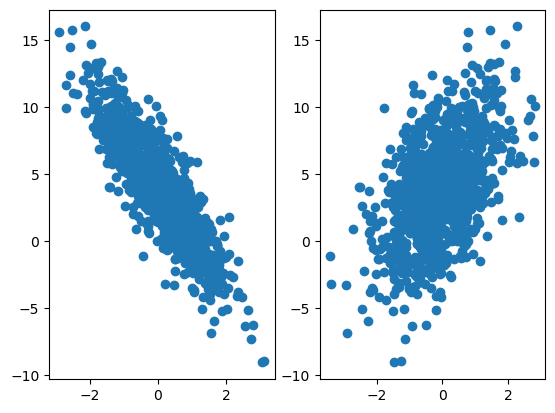

In [17]:
fig = plt.figure()
ax = fig.add_subplot(1, 2, 1)
plt.scatter(features[:,1],labels)
ax = fig.add_subplot(1, 2, 2)
plt.scatter(features[:,0],labels)

In [10]:
def linreg(X, w, b):  #@save
    """线性回归模型"""
    return torch.matmul(X, w) + b

In [11]:
def squared_loss(y_hat, y):  #@save
    """均方损失"""
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

In [12]:
def sgd(params, lr, batch_size):  #@save
    """小批量随机梯度下降"""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

In [16]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss
optimizer = sgd

batch_size = 10
w = torch.normal(0, 0.01, size=(2,1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

for epoch in range(num_epochs):
    for X, y in data_iter(features, labels,batch_size):
        l = loss(net(X, w, b), y)  # X和y的小批量损失
        # 因为l形状是(batch_size,1)，而不是一个标量。l中的所有元素被加到一起，
        # 并以此计算关于[w,b]的梯度
        l.sum().backward()
        optimizer([w, b], lr, batch_size)  # 使用参数的梯度更新参数
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')
        
print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差: {true_b - b}')        

epoch 1, loss 0.052614
epoch 2, loss 0.000233
epoch 3, loss 0.000049
w的估计误差: tensor([ 0.0003, -0.0002], grad_fn=<SubBackward0>)
b的估计误差: tensor([0.0004], grad_fn=<RsubBackward1>)


# 2. Implemention based on pytorch

torch.nn.Sequential(torch.nn.Linear(1, 1, bias=False))中使用nn.Sequential类的构造函数，将线性层作为参数传递给它，然后返回一个包含该线性层的神经网络模型；

build_model2和build_model1功能一样，使用add_module()方法向其中添加了一个名为linear的子模块；

In [21]:
# 生成数据集
import numpy as np
import torch
from torch.utils import data

In [22]:
# 读取数据集
# 我们可以调用框架中现有的API来读取数据。 我们将features和labels作为API的参数传递，并通过数据迭代器指定batch_size。 此外，布尔值is_train表示是否希望数据迭代器对象在每个迭代周期内打乱数据。
def load_array(data_arrays, batch_size, is_train=True):  #@save
    """构造一个PyTorch数据迭代器"""
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)



Q: 在 dataset = data.TensorDataset(*data_arrays)中，*data_arrays前面的 “ * ” 是什么意思呢？有什么作用？

A: f(*x)表示x为元组，所有对x的操作都应将x视为元组类型进行,，即所有传入f(*x）的变量都将作为元组x的元素之一。

In [27]:
num_features = 3
true_w = torch.randn(num_features,1)
true_b = torch.randn(1)
X,y = synthetic_data(true_w, true_b, 0.01, 1000)

batch_size = 10
data_iter = load_array((X,y), batch_size)

# 使用data_iter的方式与我们在 3.2节中使用data_iter函数的方式相同。为了验证是否正常工作，让我们读取并打印第一个小批量样本。 与 3.2节不同，这里我们使用iter构造Python迭代器，并使用next从迭代器中获取第一项。
next(iter(data_iter))

[tensor([[-0.3601,  1.6274,  0.8729],
         [ 0.0845,  0.7090,  0.4937],
         [-0.7611, -0.8109, -1.4277],
         [ 0.2629, -0.6272,  1.7259],
         [ 0.9314,  0.8798, -0.0460],
         [-0.3106,  0.3295, -0.3607],
         [-0.4191, -1.0483, -0.4834],
         [-0.1305,  0.4221,  0.3388],
         [-0.3391, -0.8764,  0.9843],
         [-0.3285,  0.0898, -0.6579]]),
 tensor([[2.3706],
         [2.3218],
         [1.0185],
         [2.2230],
         [2.8724],
         [1.8262],
         [1.3047],
         [2.0735],
         [1.6229],
         [1.7109]])]

In [28]:
# nn是神经网络的缩写
# 通过net[0]选择网络中的第一个图层， 然后使用weight.data和bias.data方法访问参数。 我们还可以使用替换方法normal_和fill_来重写参数值。
from torch import nn

net = nn.Sequential(nn.Linear(num_features, 1))
net[0].weight.data.normal_(0, 0.01)
net[0].bias.data.fill_(0)

loss = nn.MSELoss()

trainer = torch.optim.SGD(net.parameters(), lr=0.03)

In [29]:
num_epochs = 3
for epoch in range(num_epochs):
    for X, y in data_iter:
        l = loss(net(X) ,y)
        trainer.zero_grad()
        l.backward()
        trainer.step()
    l = loss(net(features), labels)
    print(f'epoch {epoch + 1}, loss {l:f}')
    
w = net[0].weight.data
print('w的估计误差：', true_w - w.reshape(true_w.shape))
b = net[0].bias.data
print('b的估计误差：', true_b - b)    

epoch 1, loss 5.217813
epoch 2, loss 5.200994
epoch 3, loss 5.199309
w的估计误差： tensor([[-0.0009],
        [-0.0004],
        [-0.0004]])
b的估计误差： tensor([-0.0005])


Q: 如果将小批量的总损失替换为小批量损失的平均值，需要如何更改学习率？

A: 应该把学习率除以batch_size，因为默认参数是’mean’，换成’sum’需要除以批量数，一般会采用默认，因为这样学习率可以跟batch_size解耦

In [37]:
def train(model, loss, optimizer, X, y):
    '''
    将pytorch通用的训练步骤封装为一个函数以方便使用
    model：神经网络模型，通常是一个继承自nn.Module的类的实例； 
    loss：损失函数，用于计算模型的预测值与真实值之间的差异； 
    optimizer：优化器，用于更新模型的参数； 
    x：输入数据，是一个torch.Tensor类型的张量； 
    y：目标数据，是一个torch.Tensor类型的张量；
    '''
    # 将模型设置为训练模式，即启用dropout和batch normalization等训练时使用的特殊操作；
    model.train()
    # 将优化器的梯度缓存清零，以便进行新一轮的梯度计算；
    optimizer.zero_grad()
    # 将输入数据传递给模型，计算模型的预测值，并将预测值与目标数据传递给损失函数，计算损失值；
    #fx = model.forward(x.view(len(x), 1)).squeeze()
    fx = model.forward(X)
    output = loss.forward(fx, y)
    # 对损失值进行反向传播，计算模型参数的梯度；
    output.backward()
    # 使用优化器更新模型参数，以最小化损失值；
    optimizer.step()
    return output.item() #返回损失值的标量值；

In [44]:
def build_model1(num_features):
    return torch.nn.Sequential(
        torch.nn.Linear(num_features, 1, bias=False)
    )

def build_model2():
    model = torch.nn.Sequential()
    model.add_module("linear", torch.nn.Linear(1, 1, bias=False))
    return model

In [45]:
# 设置随机数生成器的种子，以确保在每次运行时生成的随机数序列相同，该函数接受一个整数参数作为种子。
# 可以在训练神经网络等需要随机数的场景中使用，以确保结果的可重复性；
torch.manual_seed(42)

In [46]:
# 训练数据生成
w_true = 2
b_true = 1.2
X = torch.linspace(-1, 1, 101, requires_grad=False) # 起始值、终止值和元素个数. Note the 'requires_grad' parameter
y = w_true * X + b_true + torch.randn(X.size()) * 0.33
# print("X: ", X.numpy(), ", Y: ", Y.numpy())

In [47]:
num_features = 3
true_w = torch.randn(num_features,1)
true_b = torch.randn(1)
X,y = synthetic_data(true_w, true_b, 0.01, 1000)

batch_size = 10
data_iter = load_array((X,y), batch_size)

In [49]:
# 模型构建
model = build_model1(num_features)

# 定义损失函数
loss = torch.nn.MSELoss(reduction='mean')

# 优化器对象生成
# optim.SGD(model.parameters(), lr=0.01, momentum=0.9)实现随机梯度下降（Stochastic Gradient Descent，SGD）优化算法；
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

batch_size = 10 # Define the size for the mini-batch stochastic gradient. 
for i in range(20): # epoch loop
    cost = 0.
    num_batches = len(X) // batch_size
    for k in range(num_batches): # batch loop
        start, end = k * batch_size, (k + 1) * batch_size
        # Accumulate cost accross the whole epoch to show the status of the training process
        # Should add shuffling operation, which may help to accelarate the training?
        cost += train(model, loss, optimizer, X[start:end], y[start:end])

    # 打印当前训练的轮次和损失值
    print("Epoch = %d, cost = %s" % (i + 1, cost / num_batches))

w = next(model.parameters()).data
print("w = {0}".format(w))


Epoch = 1, cost = 0.3462873976537958
Epoch = 2, cost = 0.0038827377022244034
Epoch = 3, cost = 0.003840417140163481
Epoch = 4, cost = 0.0038400658359751105
Epoch = 5, cost = 0.0038400647370144727
Epoch = 6, cost = 0.0038400647370144727
Epoch = 7, cost = 0.0038400647370144727
Epoch = 8, cost = 0.0038400647370144727
Epoch = 9, cost = 0.0038400647370144727
Epoch = 10, cost = 0.0038400647370144727
Epoch = 11, cost = 0.0038400647370144727
Epoch = 12, cost = 0.0038400647370144727
Epoch = 13, cost = 0.0038400647370144727
Epoch = 14, cost = 0.0038400647370144727
Epoch = 15, cost = 0.0038400647370144727
Epoch = 16, cost = 0.0038400647370144727
Epoch = 17, cost = 0.0038400647370144727
Epoch = 18, cost = 0.0038400647370144727
Epoch = 19, cost = 0.0038400647370144727
Epoch = 20, cost = 0.0038400647370144727
w = tensor([[-1.3563,  0.1759, -0.8243]])


TODO: 

(1) 向多维扩展

(2) 原始数据可视化

(3) 训练结果可视化

(4) 解析解 analytic solution

(5) 如果不用MSE loss呢？有什么其它的alternatives?